# Inference for latent variable ebms 

unsupervised / unconditional case

## TODO 
- really annoying use of global jupyter variables. maybe split into multiple notebooks or improve naming scheme

## References
- https://www.youtube.com/watch?v=xA_OPjRby5g&ab_channel=AlfredoCanziani
- https://www.youtube.com/watch?v=XIMaWj5YjOQ&ab_channel=AlfredoCanziani

## 1. Creating horn dataset 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

def graph_3d(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='g', marker='o')
    ax.set_xlabel('x')
    ax.set_ylabel('y1')
    ax.set_zlabel('y2')
    plt.show()

def graph_2d(y1, y2):
    fig = plt.figure()
    ax = fig, ax = plt.subplots(1,1)
    ax.scatter(*y, c='g', marker='o')
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    plt.show()
    
    
def f(y1, y2):
    g = decoder(z)
    y = np.array([y1, y2])
    y_expanded = g.T[:, :, np.newaxis, np.newaxis]
    squared_error = np.sum((y - y_expanded) ** 2, axis=1)
    free_energy = np.min(squared_error, axis=0)
    return free_energy
    

def graph_2d_contour(y1, y2):
    fig = plt.figure()
    ax = fig, ax = plt.subplots(1,1, figsize=(10,10))
    y1_range = np.linspace(min(y1), max(y1), 100)
    y2_range = np.linspace(min(y2), max(y2), 100)
    Y1, Y2 = np.meshgrid(y1_range, y2_range)
    Z = f(Y1, Y2)
    contour = ax.contourf(Y1, Y2, Z, levels=15, alpha=0.5)
    ax.scatter(*y, c='r', marker='o')
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    cbar = plt.colorbar(contour)
    cbar.set_label('Function Value')
    plt.show()

In [172]:
np.stack([np.ones(3), np.arange(3)])


array([[1., 1., 1.],
       [0., 1., 2.]])

In [168]:
def rho_func(x):
    c1 = alpha * x + beta * (1 - x)
    c2 = beta * x + alpha * (1 - x)
    return np.stack([c1,c2]) * np.exp(2*x)

def y_func(rho):
    return np.stack([rho[0] * np.cos(theta) + epsilon, rho[1] * np.sin(theta) + epsilon])

# hyperparams
N = 500
alpha = 1.5 # elipe y
beta = 2  # elipse x width 

# data 
epsilon = np.random.uniform(0, (1/20)**2)
x_data = np.random.uniform(0,1,N)

# param 
theta = np.random.uniform(0, 2 * np.pi, N)

# calculate rho then y
rho = rho_func(x_data) # rho pushfoward R to R^2
y_data = y_func(rho)

print(x_data.shape, y_data.shape, rho.shape)

(500,) (2, 500) (2, 500)


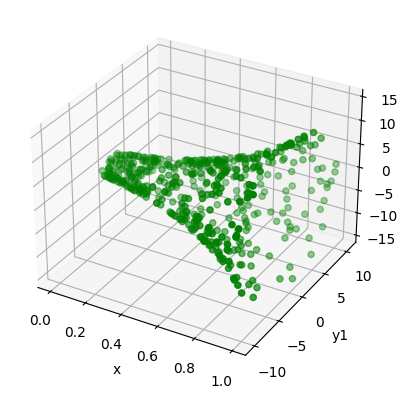

In [169]:
graph_3d(x_data, *y_data)

Any x has infinite many ys. A standard neural network can't solve this. You could approximate with 10k discrete outputs, but we cant have infinite outputs. 



# Unconditional case - cooked example 

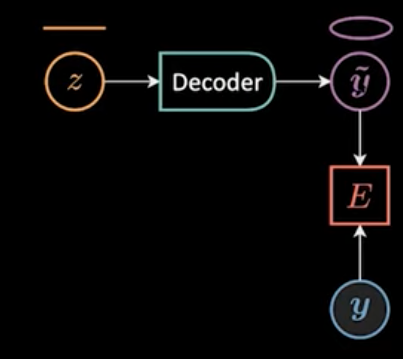

Start by taking a slice at x=0 with 24 data points 

<Figure size 640x480 with 0 Axes>

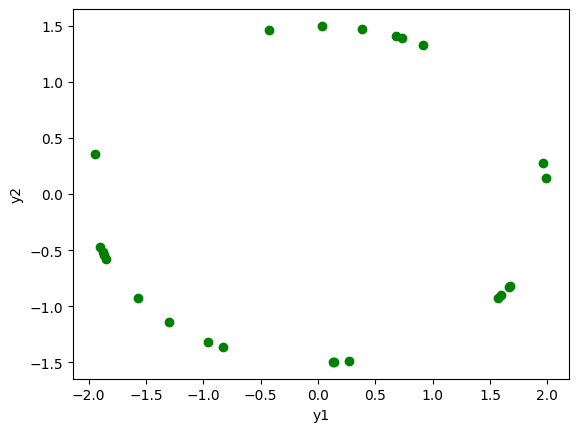

In [20]:
# set N low, with linspace across 2pi 
N = 24 
theta = np.random.uniform(0, 2 * np.pi, N)

rho = np.array([2, 1.5]) # set rho arbitaryily for cooked example 
y = y_func(rho)

graph_2d(*y)

make latent z which varies around circle (2 pi ) uniformly with 48 points

In [21]:
y.shape

(2, 24)

Text(0.5, 0.98, 'Energy function per data point. Each cell is over latent')

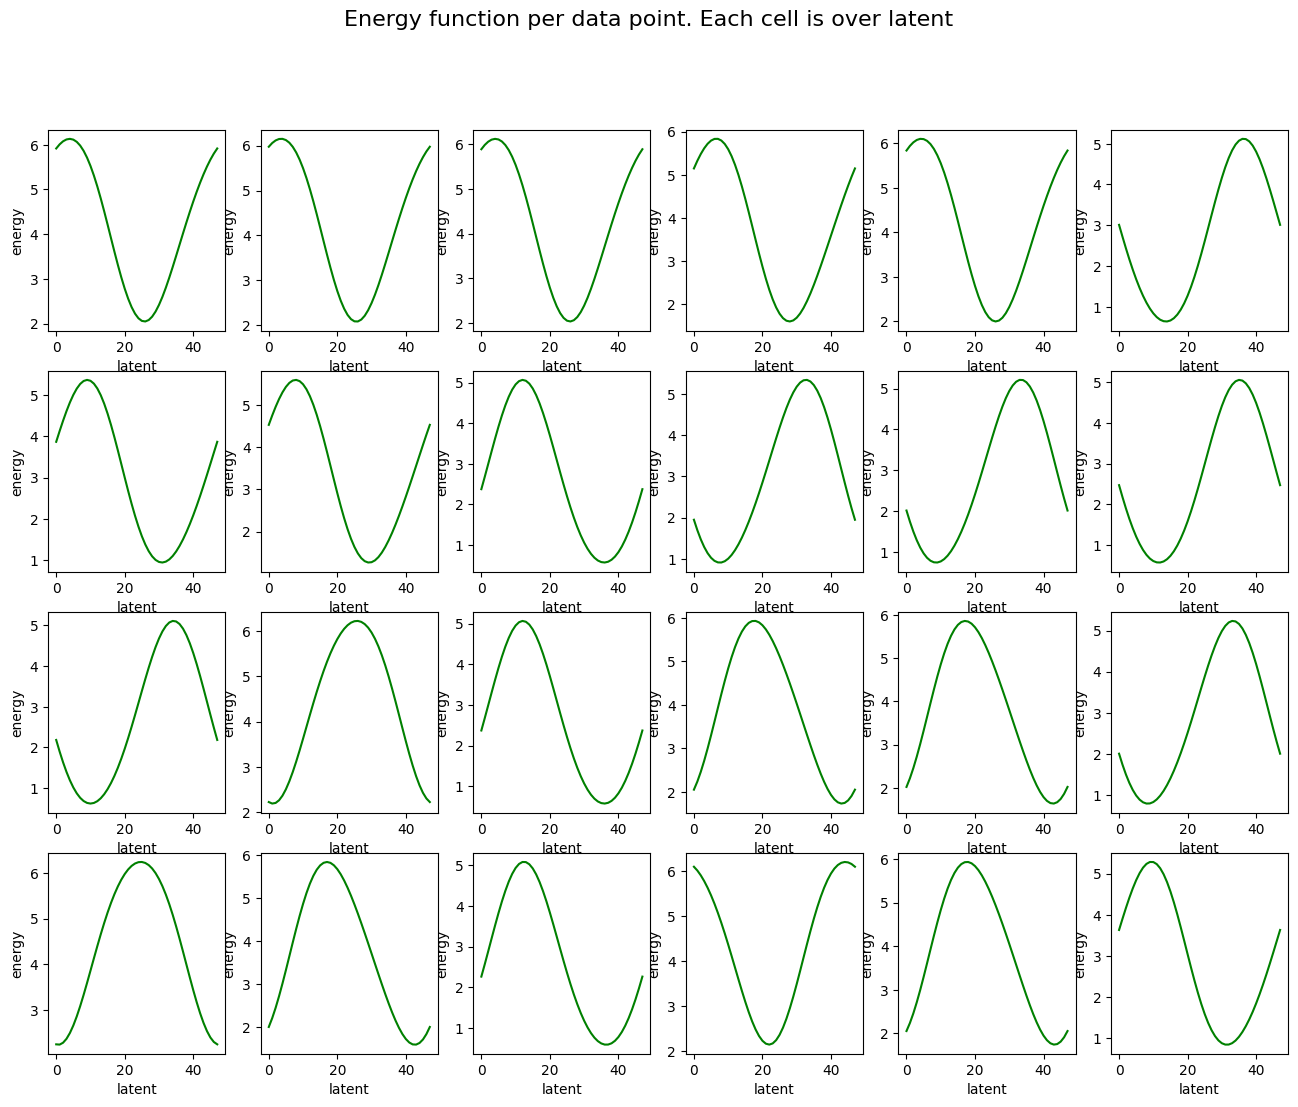

In [22]:

W_CONSTANT = np.array([0.5,0.75]) # decoder parameters 
def energy_func(y : np.array) -> np.array:
    """sum squared errors between each datapoint y and each decoded latent"""
    #assert(len(y.shape) == 2)
    g = decoder(z)
    energies = np.array([(y[0, i] - g[0])**2 + (y[1, i] - g[1])**2 for i in range(y.shape[1])])
    return energies

def decoder(z : np.array, w=W_CONSTANT) -> np.array:
    """decoder designed for this toy problem"""
    return np.stack([w[0] * np.cos(z), w[1] * np.sin(z)])


z = np.linspace(0, 2 * np.pi, N*2) # latent variables 

E = energy_func(y)

# draw all energies 
fig, axs = plt.subplots(4,6,figsize=(16,12))
for i in range(4):
    for j in range(6):
        index = i * 6 + j
        axs[i,j].plot(np.arange(48), E[index], c='g')
        #axs[i,j].set_title(f'y={index}')
        axs[i,j].set_ylabel('energy')
        axs[i,j].set_xlabel('latent')
fig.suptitle('Energy function per data point. Each cell is over latent', fontsize=16)

Zero temperature limit for free energy 

$$
F_\infty (y) = \min_z E(y,z)
$$

optimisation can be exhaustive search if small discrete. or conjugate graidne,t gradient descent, line serach, LBFGS

In [23]:
E.shape

(24, 48)

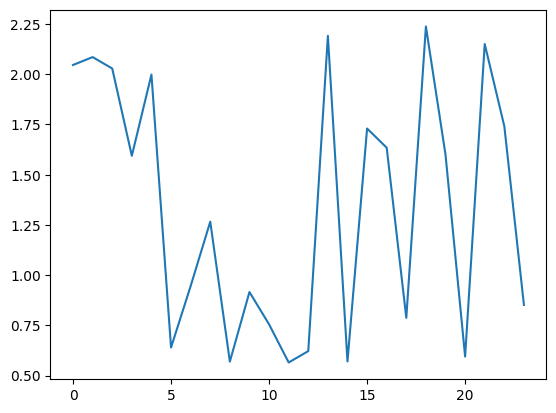

In [24]:
zero_temp_limit_free_energy = np.min(E, axis=1)
plt.plot(np.arange(len(zero_temp_limit_free_energy)), zero_temp_limit_free_energy)

visualising the manifold of the network

outer subtract by filling np.newaxis where want the dimension to carry

<Figure size 640x480 with 0 Axes>

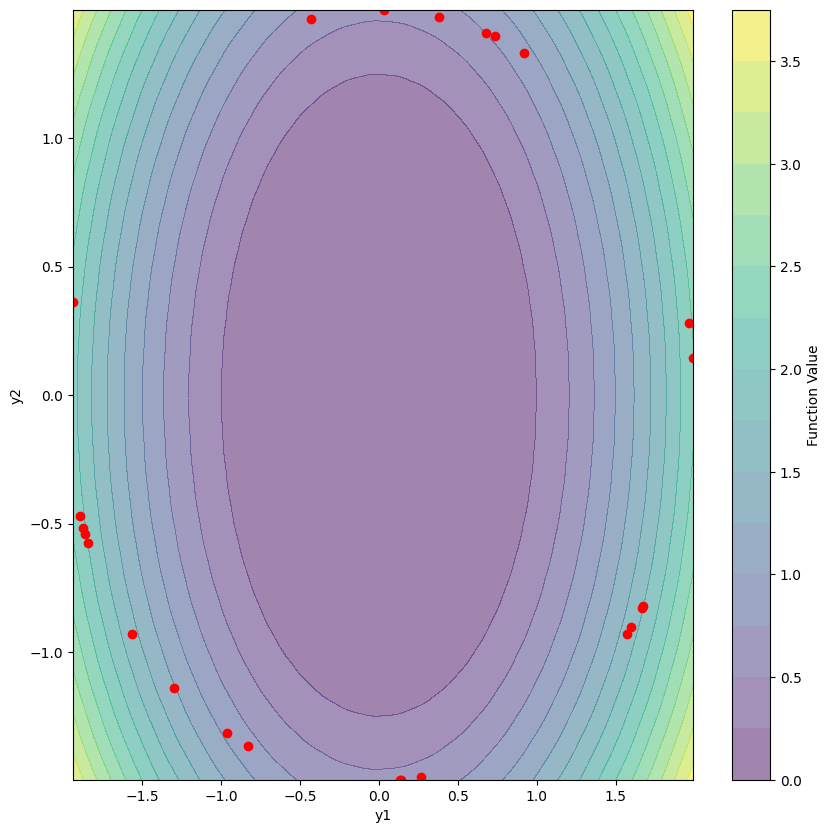

In [25]:
graph_2d_contour(*y)

Can see our analytical fake decoder isn't very good. It should be 0 enetrgy around the dataset. 

<br>

# Non-zero temperature limit. beta=1 not infinity

Text(0.5, 0.98, 'Examples of different free energy with 1 for temperature. gives softer calculation')

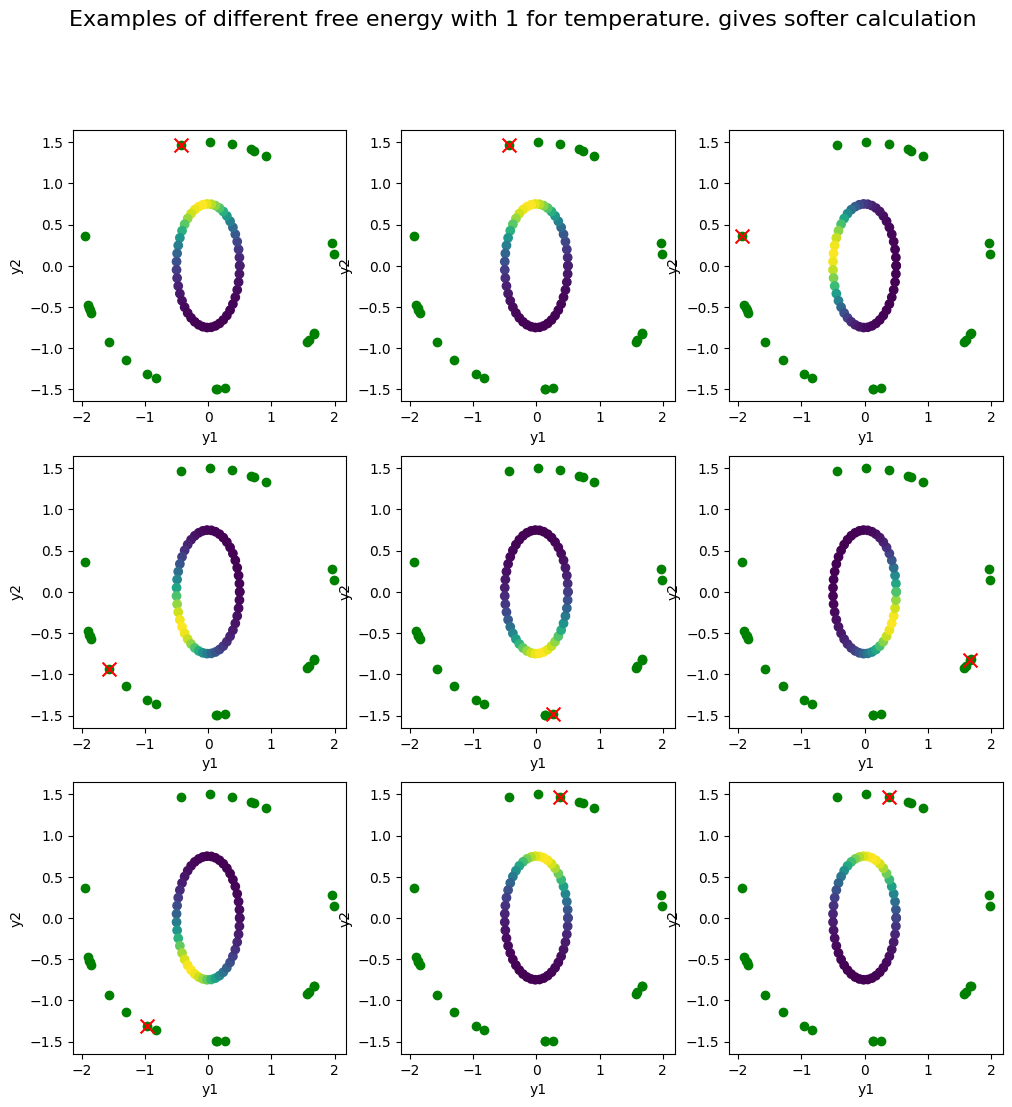

In [26]:
def softmin(values):
    """assume beta hyperparamer = 1 """
    softmin_values = torch.logsumexp(torch.from_numpy(E), 1)
    softmin_values = np.array(softmin_values)
    return softmin_values

def discretised_free_energy(beta=1):
    """as function of E... total tabular energy. approximate with softmin"""
    assert(len(E.shape) == 2)
    delta_z = 2 * np.pi / 48
    z_domain = 2 * np.pi 
    inner = np.exp(-beta * E) * delta_z
    F_beta = -(1 / beta) * np.log((1/z_domain) * np.sum(inner))
    return F_beta 

def softmin_free_energy():
    return softmin(E)


fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        
        rand_point = np.random.randint(y.shape[1])
        free_energy = softmin_free_energy()
        values = np.exp(-E)[rand_point]
        g = decoder(z)
        
        axs[i,j].scatter(*y, c='g', marker='o')
        axs[i,j].scatter(*g, c=values, marker='o')
        axs[i,j].scatter(*y[:, rand_point], marker='x', color='r', s=100)
        axs[i,j].set_xlabel('y1')
        axs[i,j].set_ylabel('y2')
fig.suptitle('Examples of different free energy with 1 for temperature. gives softer calculation', fontsize=16)

colder beta, less points considered. 

<br>

# Training 

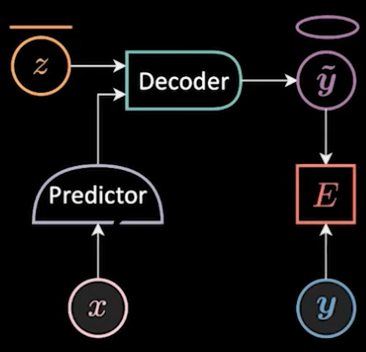


functional maps function to scalar

simplest approach: loss is free energy at location 

or hinge loss functional? 

QUESTION: why not just fgood - fbad? becasue it will be pushed to infiinity. want a mechanism to stop training 


todo:
- need inference procedure (optimisation)
- need network training coreectly

In [12]:
# %reset 

In [27]:
def loss_energy_functional(energy_function, y):
    return energy_function(y)

def loss_hinge_functional(energy_function, y_good, y_bad, margin=1):
    return  np.max(0,m - F(y_good) - F(y_bad))

def loss_log_functional(energy_function, y_good, y_bad):
    """soft hinge"""
    return np.log(1 + np.exp(F(y_good) - F(y_bad)))

will use the energy loss functional. now defining the predictor network:

In [184]:
x_data.shape, y_data.shape

((100,), (2, 100))

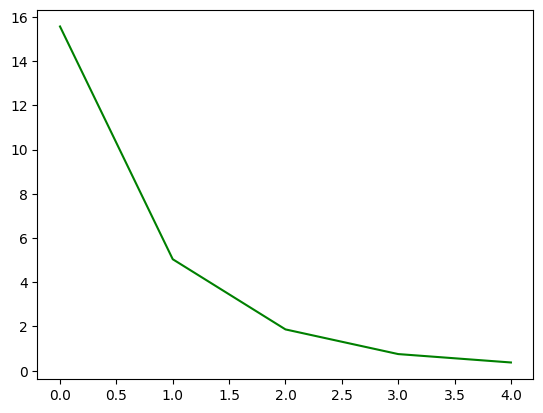

In [210]:
from torch import nn

class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU() # aka positive part 
        self.linear1 = nn.Linear(1, 8)
        self.linear2 = nn.Linear(8, 8)
        self.linear3 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x 

predictor = Predictor()
N = 100
num_z = 48
theta = np.random.uniform(0, 2 * np.pi, N)
x_data = np.linspace(0,1,N)
rho = rho_func(x_data) 
y_data = y_func(rho)

z = np.linspace(0, 2 * np.pi, num_z) # latent variables 
z = torch.tensor(z, dtype=torch.float32)
optimizer = torch.optim.SGD(predictor.parameters(), lr=3e-4, momentum=0.9)

#assert(len(y[0]) == len(x))
losses = []
for epoch in range(5):  
    epoch_loss = []
    for i in range(len(x_data)):
        # if i > 50:
        #     break
        optimizer.zero_grad()
        
        # forward 
        w = predictor(torch.Tensor([x_data[i]]))
        g = torch.stack([w[0] * torch.cos(z), w[1] * torch.sin(z)], dim=1)

        # have obs y, find closest decoded g, error is sse 
        E = (y_data[:,i][0] - g[:, 0])**2 + (y_data[:,i][1] - g[:, 1])**2
        #print(E.shape)
        loss = torch.min(E)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.detach().numpy())
    losses.append(np.mean(np.array(epoch_loss)))
plt.plot(np.arange(len(losses)), losses, c='g')

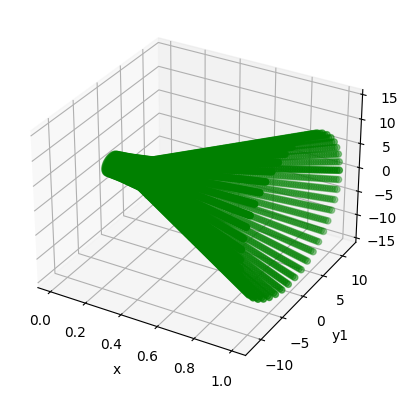

In [211]:
preds = predictor(torch.Tensor([x_data[:, np.newaxis]]))[0].detach().numpy()
#z = z.detach().numpy()
ypreds = []
for i in range(N):
    w = preds[i]
    y_hat = np.stack([w[0] * np.cos(z), w[1] * np.sin(z)])
    for j in range(num_z):
        ypreds.append([x_data[i], y_hat[0, j], y_hat[1, j]])
ypreds = np.array(ypreds)
graph_3d(*ypreds.T)

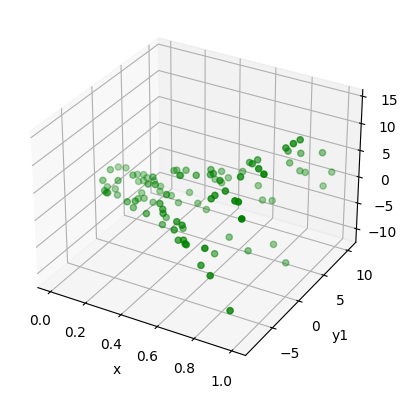

In [212]:
graph_3d(x_data, *y_data)